In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
#Convert date coulmns to specific format
dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
#Read csv file
df = pd.read_csv(r'D:/freelance/crude oil prediction/BrentOilPrices.csv',parse_dates=['Date'], date_parser=dateparse)
#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [3]:
# Print some data rows.
df.head()

,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77


In [4]:
#Read dataframe info
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [5]:
DfInfo(df)

,Price
column type,float64
null values (nb),0
null values (%),0.0


In [6]:
df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=5016, freq=None)

In [7]:
y = df['Price'].resample('MS').mean()

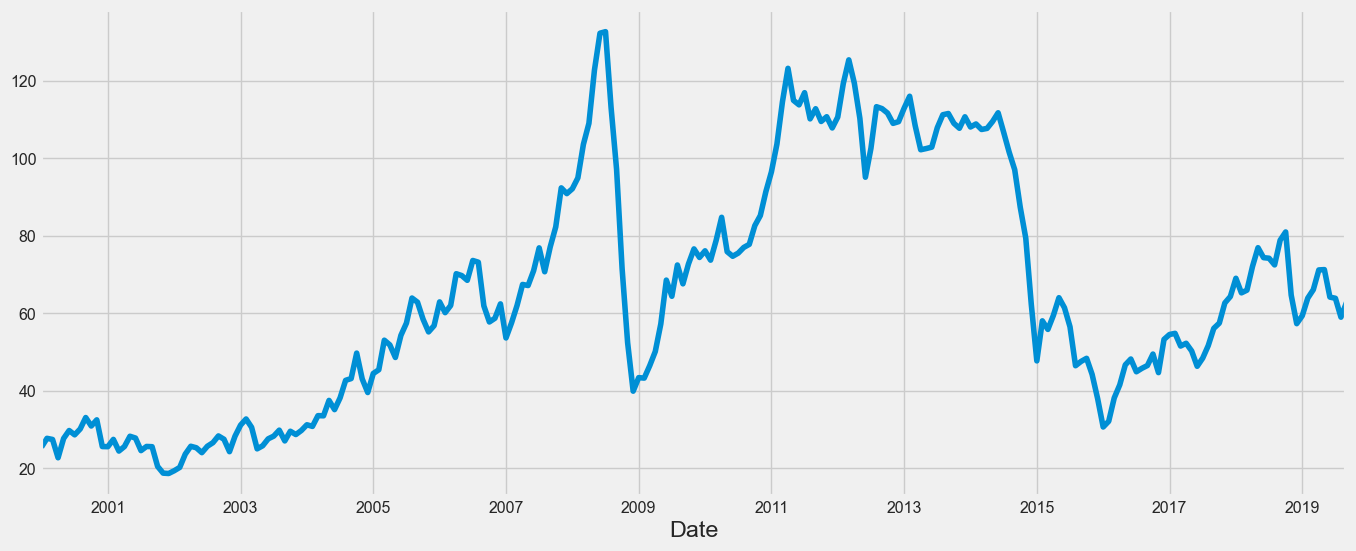

In [8]:
y.plot(figsize=(15, 6))
plt.show()

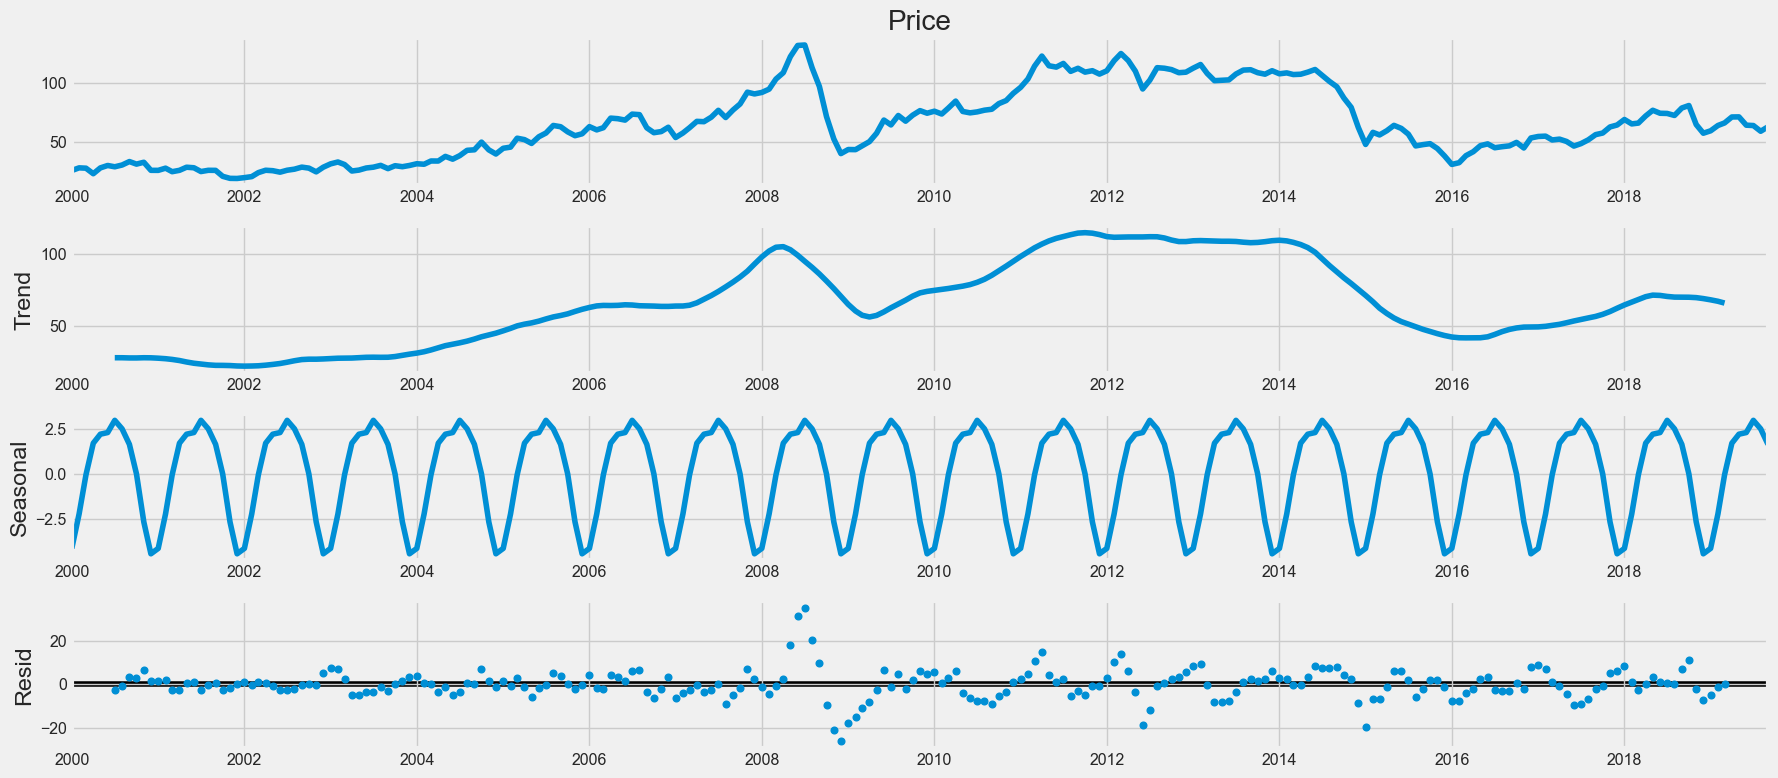

In [9]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [11]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [12]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [13]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
228/228 [==============================] - 12s 41ms/step - loss: 0.0058 - val_loss: 0.0915 - lr: 0.0010
Epoch 2/20
228/228 [==============================] - 8s 35ms/step - loss: 0.0142 - val_loss: 0.0969 - lr: 0.0010
Epoch 3/20
228/228 [==============================] - 8s 35ms/step - loss: 0.0226 - val_loss: 0.0968 - lr: 0.0010
Epoch 4/20
228/228 [==============================] - 8s 35ms/step - loss: 0.0206 - val_loss: 0.0695 - lr: 0.0010
Epoch 5/20
228/228 [==============================] - 8s 35ms/step - loss: 0.0074 - val_loss: 0.0044 - lr: 0.0010
Epoch 6/20
228/228 [==============================] - 8s 37ms/step - loss: 0.0019 - val_loss: 0.0037 - lr: 0.0010
Epoch 7/20
228/228 [==============================] - 8s 36ms/step - loss: 0.0017 - val_loss: 0.0039 - lr: 0.0010
Epoch 8/20
228/228 [==============================] - 8s 36ms/step - loss: 0.0017 - val_loss: 0.0053 - lr: 0.0010
Epoch 9/20
228/228 [==============================] - 8s 36ms/step - loss: 0.0017 - val

In [15]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

45/45 [==============================] - 1s 15ms/step


In [16]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 1.669208442621064
Train Root Mean Squared Error: 2.3117147802161973
Test Mean Absolute Error: 1.5518237522670202
Test Root Mean Squared Error: 1.9939739443365028


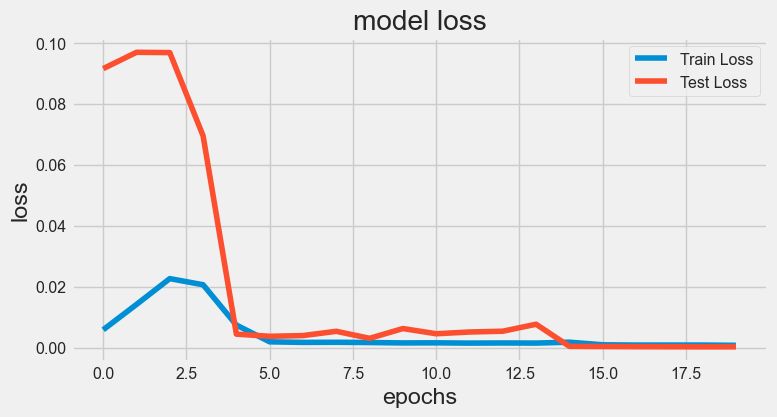

In [17]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

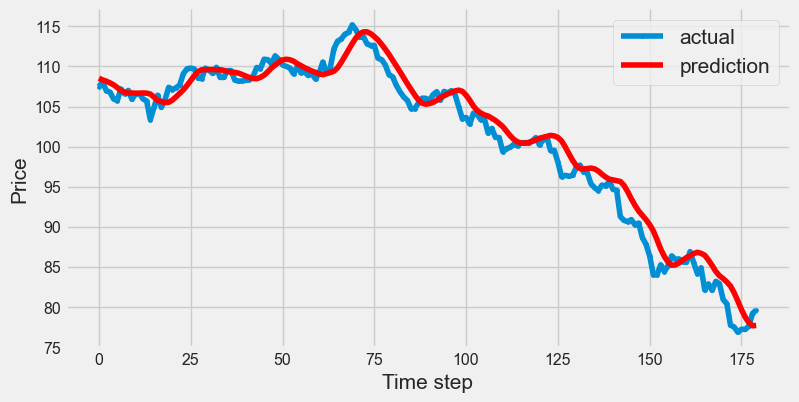

In [18]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
Thank you!!!!